# Acknowledgements

- Thanks to Xhulu for their wonderful kernal.[click here](https://www.kaggle.com/xhlulu/alaska2-efficientnet-on-tpus)
- Trying different model like resnet101, Xception model, inception_v2, vgg16, Densenet121.
- Experimented with number of epochs.

# Other References And some wonderful kernal for kick start...

- Best and well documented kernal for kick start is mr.Tanul singh.[Click here](https://www.kaggle.com/tanulsingh077/steganalysis-complete-understanding-and-model)
- Another kernal is of Mr.Prasant banarjee.[click here](https://www.kaggle.com/prashant111/alaska2-image-steganalysis-all-you-need-to-know)
- Another best kernal is of Wei hao khoong.[click here](https://www.kaggle.com/khoongweihao/alaska2-blending-efficientnets-on-tpus)
- Kernal of mine on handwritten grapheme.[click here](https://www.kaggle.com/saife245/handwritten-grapheme-classification-resnet-0-97)

## My Other Works on kaggle...

- NeuroImaging problem on kaggle.[click here](https://www.kaggle.com/saife245/neuroimaging-in-depth-understanding-eda-model)
- Football match prediction.[click here](https://www.kaggle.com/saife245/football-match-prediction)
- Hand written Grapheme Classification.[click here](https://www.kaggle.com/saife245/handwritten-grapheme-classification-resnet-0-97)
- Cutmix_Gridmask_Mixup_Cutout.[click here](https://www.kaggle.com/saife245/cutmix-vs-mixup-vs-gridmask-vs-cutout)


# Imports

In [ ]:
import math, re, os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.applications.xception as xcep
import tensorflow.keras.applications.densenet as dense
from sklearn import metrics
from sklearn.model_selection import train_test_split

# TPU Strategy and other configs 

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 10 # original 10
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Load label and paths

In [ ]:
def append_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

In [ ]:
sub = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')
train_filenames = np.array(os.listdir("/kaggle/input/alaska2-image-steganalysis/Cover/"))

In [ ]:
np.random.seed(0)
positives = train_filenames.copy()
negatives = train_filenames.copy()
np.random.shuffle(positives)
np.random.shuffle(negatives)

jmipod = append_path('JMiPOD')(positives[:10000])
juniward = append_path('JUNIWARD')(positives[10000:20000])
uerd = append_path('UERD')(positives[20000:30000])

pos_paths = np.concatenate([jmipod, juniward, uerd])

In [ ]:
test_paths = append_path('Test')(sub.Id.values)
neg_paths = append_path('Cover')(negatives[:30000])

In [ ]:
train_paths = np.concatenate([pos_paths, neg_paths])
train_labels = np.array([1] * len(pos_paths) + [0] * len(neg_paths))

In [ ]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, random_state=2020)

# Create Dataset objects

In [ ]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    #adding extra augmentation
    image = tf.image.random_saturation(image, 0, 2)
    image = tf.image.random_brightness(x, 0.2)
    
    if label is None:
        return image
    else:
        return image, label

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

## Let analyze the few model output....
### NOte;- model performance after 10 Epochs
- Model - Resnet101
- loss: 0.6454 
- accuracy: 0.5869 
- val_loss: 0.6673 
- val_accuracy: 0.5621
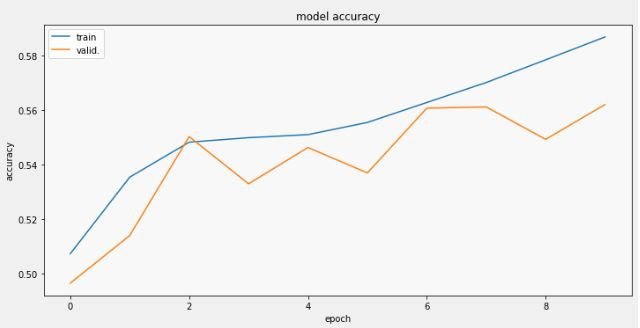

- Model - InceptionResNetV2
- loss: 0.6852 
- accuracy: 0.5263 
- val_loss: 0.6972 
- val_accuracy: 0.4853
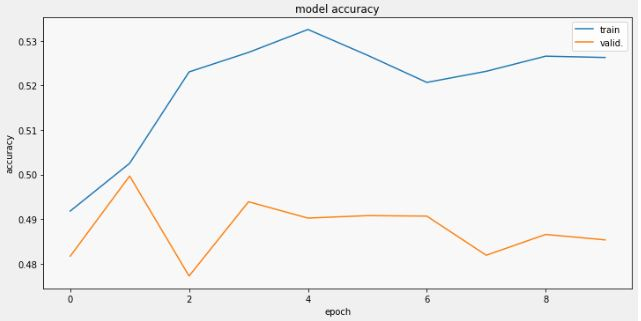

- Model - Squeezenet
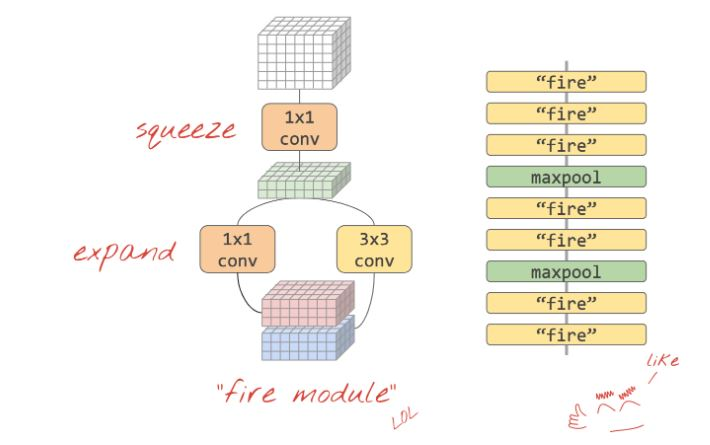
- loss: 4.1260  
- accuracy: 0.2927 
- val_loss: 4.0705 
- val_accuracy: 0.4789
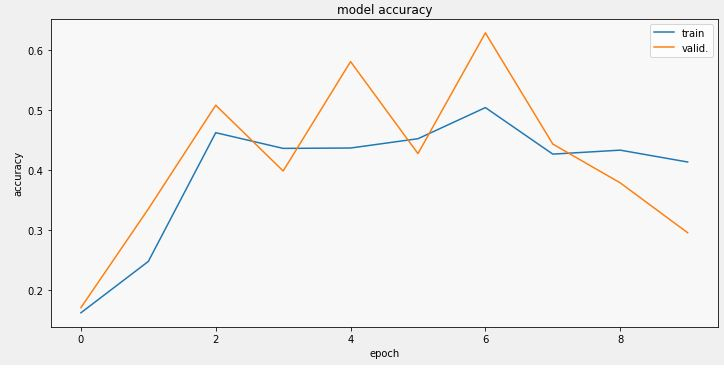

- MOdel -Xception
- loss: 0.5662 
- accuracy: 0.6784 
- val_loss: 0.6729 
- val_accuracy: 0.5794


- Model - Densenet
- loss: 0.5908 
- accuracy: 0.6535 
- val_loss: 0.6493 
- val_accuracy: 0.5828

### Best Accuracy obtain at Densenet101 and Xception.

# Modelling

## Helper Functions

In [ ]:
def build_lrfn(lr_start=0.00001, lr_max=0.00008, 
               lr_min=0.000001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

## Load Model into TPU

In [ ]:
with strategy.scope():
    # Xception model
    model = tf.keras.Sequential([
        xcep.Xception(
            input_shape=(512, 512, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1, activation='sigmoid')
    ])
        
    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Densenet121 model
    model2 = tf.keras.Sequential([
        dense.DenseNet121(
            input_shape=(512, 512, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1, activation='sigmoid')
    ])
        
    model2.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    

In [ ]:
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')

In [ ]:
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

## Training Xception model

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[reduce_lr_loss, lr_schedule],#callbacks=[checkpoint1, reduce_lr_loss, lr_schedule],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset
)

In [ ]:
model.save("model_Xception.h5")

In [ ]:
pred1 = model.predict(test_dataset, verbose=1)
sub.Label = pred1
sub.to_csv('submission_xcept.csv', index=False)
sub.head()

## Training Densenet Model

In [ ]:
model2.summary()

In [ ]:
history2 = model2.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[reduce_lr_loss, lr_schedule],#callbacks=[checkpoint2, reduce_lr_loss, lr_schedule],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset
)

In [ ]:
model2.save("model_Densenet121.h5")

In [ ]:
pred2 = model2.predict(test_dataset, verbose=1) # EfficientNetB7
sub.Label = pred2
sub.to_csv('submission_dense.csv', index=False)
sub.head()

# Evaluation

In [ ]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Xception Training Curve

In [ ]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy', 212)

## Densenet121 Training Curve

In [ ]:
display_training_curves(
    history2.history['loss'], 
    history2.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history2.history['accuracy'], 
    history2.history['val_accuracy'], 
    'accuracy', 212)

# Submission

## Building Ensemble...

In [ ]:
sub.Label = 0.51*pred1 + 0.5*pred2
sub.to_csv('submission.csv', index=False)
sub.head()

## IF you like the kernal, Please upvote it.